## Part 1: SWI vs SWI uniforme

L'objectif de cette partie est de construire un modèle capable de traduire le SWI quotidien (Safran) en SWI Uniforme mensuel (l'indice officiel de sécheresse), en intégrant les spécificités géologiques du sol.


** Étape 1 : Fusion et Préparation des Bases

L'enjeu est de passer d'une donnée ponctuelle (grille Safran) à une donnée administrative (commune) tout en y injectant les propriétés du sol.

Importation des données du SWI QUOTIDIEN

In [1]:
import pandas as pd

# Lire 
swi=pd.read_csv('https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/REF_CC/SIM_MENS/MENS_SIM2_latest-2020-2025.csv.gz',sep=';', encoding='latin-1')

swi.head(10)

,LAMBX,LAMBY,DATE,PRENEI_MENS,PRELIQ_MENS,PRETOTM_MENS,T_MENS,EVAP_MENS,ETP_MENS,PE_MENS,...,RUNC_MENS,SPI1_MENS,SPI3_MENS,SPI6_MENS,SPI12_MENS,SSWI1_MENS,SSWI3_MENS,SSWI6_MENS,SSWI12_MENS,ECOULEMENT_MENS
0,600,24010,202001,0.0,104.5,104.5,8.9,37.3,18.2,67.2,...,11.5,-0.04,0.90,1.58,1.08,0.30,1.75,2.09,1.55,0.0
1,600,24010,202002,0.0,148.6,148.6,9.6,65.9,27.6,82.7,...,15.7,1.12,0.66,1.49,1.30,0.73,0.99,1.95,1.46,0.0
2,600,24010,202003,0.0,67.1,67.1,8.8,53.0,51.3,14.1,...,7.9,0.30,0.65,1.33,1.23,1.24,0.88,1.87,1.49,0.0
3,600,24010,202004,0.0,67.8,67.8,12.3,56.1,79.2,11.7,...,5.4,0.20,0.84,1.14,1.38,-0.53,0.57,1.54,1.41,0.0
4,600,24010,202005,0.0,22.0,22.0,14.6,81.3,134.6,-59.3,...,1.9,-1.29,-0.62,0.23,1.31,-0.29,0.12,0.77,1.51,0.0
5,600,24010,202006,0.0,120.3,120.3,15.6,72.4,90.3,47.9,...,7.4,1.67,0.55,0.75,1.43,0.01,-0.40,0.29,1.59,0.0
6,600,24010,202007,0.0,19.5,19.5,17.0,63.5,104.2,-44.0,...,0.6,-1.08,0.12,0.68,1.30,0.45,0.15,0.31,1.86,0.0
7,600,24010,202008,0.0,64.6,64.6,17.9,62.4,93.0,2.2,...,2.2,0.32,0.85,0.19,1.24,-0.23,0.06,0.09,1.62,0.0
8,600,24010,202009,0.0,51.8,51.8,15.8,46.0,63.6,5.8,...,1.1,-0.08,-0.46,0.08,1.21,-0.33,-0.18,-0.26,1.36,0.0
9,600,24010,202010,0.0,169.7,169.7,12.6,71.0,40.7,98.7,...,11.5,1.51,0.92,0.73,1.28,0.82,0.05,0.09,1.10,0.0


Conversion de la variable DATE

In [2]:
swi['DATE'] = pd.to_datetime(swi['DATE'], format='%Y%m')
swi['DATE'] = swi['DATE'].dt.to_period('M')
min_max_ensemble = swi['DATE'].agg(['min', 'max'])
print(min_max_ensemble)

min    2020-01
max    2025-11
Name: DATE, dtype: period[M]


Vérification des données manquantes

In [3]:
swi.isnull().sum()

LAMBX                  0
LAMBY                  0
DATE                   0
PRENEI_MENS            0
PRELIQ_MENS            0
PRETOTM_MENS           0
T_MENS                 0
EVAP_MENS              0
ETP_MENS               0
PE_MENS                0
SWI_MENS               0
DRAINC_MENS            0
RUNC_MENS              0
SPI1_MENS          65258
SPI3_MENS          64975
SPI6_MENS          64764
SPI12_MENS         64692
SSWI1_MENS         64681
SSWI3_MENS         64681
SSWI6_MENS         64681
SSWI12_MENS        64681
ECOULEMENT_MENS        0
dtype: int64

Séparation de la base d'etude et de la prédiction

In [4]:
# --- Filtrage ---

# 1. Créer le masque booléen : True pour toutes les dates À PARTIR de 2010-01-01
# On utilise l'opérateur >= (supérieur ou égal)
masque_dates_valides = swi['DATE'] >= "2025-01"
masque_dates_valides_1 = swi['DATE'] < "2025-01"
# 2. Appliquer le masque pour conserver uniquement les lignes valides
swi_25 = swi[masque_dates_valides].copy() # .copy() est une bonne pratique
swi_20_24 = swi[masque_dates_valides_1].copy()

min_max_ensemble = swi_25['DATE'].agg(['min', 'max'])
min_max_ensemble_1 = swi_20_24['DATE'].agg(['min', 'max'])
print(min_max_ensemble)
print(min_max_ensemble_1)

min    2025-01
max    2025-11
Name: DATE, dtype: period[M]
min    2020-01
max    2024-12
Name: DATE, dtype: period[M]


In [5]:
swi_20_24.shape

(593520, 22)

Importation des données du SWI Uniforme

In [7]:
#pip install requests io zipfile
import requests
import io
import zipfile

# --- CONFIGURATION ---
# Remplacez par l'URL de votre archive ZIP en ligne
url_archive_zip = 'https://donneespubliques.meteofrance.fr/donnees_libres/Txt/Swi/SWI_Package_1969-2024.zip' 
# Ajoutez ici les options si vos CSV ont des problèmes d'encodage ou de séparateur
csv_options = {
    'sep': ';',
    'encoding': 'utf-8',
    'on_bad_lines': 'skip' # Optionnel : ignore les lignes mal formatées
}
# ---------------------

liste_dataframes = []

print("1. Téléchargement de l'archive ZIP...")

# 1. Télécharger le contenu du fichier ZIP en mémoire
try:
    reponse = requests.get(url_archive_zip)
    reponse.raise_for_status() # Lève une erreur pour les codes de statut HTTP non réussis (4xx ou 5xx)

    # 2. Lire le contenu binaire de la réponse dans un objet de flux de mémoire
    bytes_io = io.BytesIO(reponse.content)
    
except requests.exceptions.RequestException as e:
    print(f"Échec du téléchargement : {e}")
    exit()

print("2. Décompression et lecture des fichiers CSV...")

# 3. Utiliser zipfile pour ouvrir le contenu du ZIP en mémoire
with zipfile.ZipFile(bytes_io, 'r') as archive_zip:
    
    # 4. Parcourir tous les fichiers dans l'archive
    for nom_fichier in archive_zip.namelist():
        # S'assurer que nous traitons uniquement les fichiers CSV et non les dossiers ou autres
        if nom_fichier.endswith('.csv'):
            print(f"   - Lecture de {nom_fichier}...")
            
            # 5. Extraire le contenu du fichier CSV dans un autre flux de mémoire
            with archive_zip.open(nom_fichier) as fichier_csv_zip:
                # 6. Lire le CSV directement dans un DataFrame
                df_temporaire = pd.read_csv(fichier_csv_zip, **csv_options)
                
                # 7. Ajouter le DataFrame à notre liste
                liste_dataframes.append(df_temporaire)

print(f"\n3. Concaténation de {len(liste_dataframes)} DataFrames...")

# 8. Concaténer tous les DataFrames de la liste verticalement (empilement)
if liste_dataframes:
    swi_unif = pd.concat(liste_dataframes, ignore_index=True)
    
    print("4. Opération terminée.")
    print(f"DataFrame final créé avec {len(swi_unif)} lignes.")
    
    # --- Optionnel : Afficher les premières lignes et sauvegarder ---
    #print("\nAperçu des données finales :")
    #print(swi_unif.head())
    
    # Pour sauvegarder le résultat final sur votre machine
    # df_final.to_csv('fichier_combine_final.csv', index=False)

else:
    print("Aucun fichier CSV trouvé ou DataFrames vides.")

1. Téléchargement de l'archive ZIP...


2. Décompression et lecture des fichiers CSV...
   - Lecture de swi.0-249.csv...
   - Lecture de swi.1000-1249.csv...
   - Lecture de swi.1250-1499.csv...
   - Lecture de swi.1500-1749.csv...
   - Lecture de swi.1750-1999.csv...
   - Lecture de swi.2000-2249.csv...
   - Lecture de swi.2250-2499.csv...
   - Lecture de swi.250-499.csv...
   - Lecture de swi.2500-2749.csv...
   - Lecture de swi.2750-2999.csv...
   - Lecture de swi.3000-3249.csv...
   - Lecture de swi.3250-3499.csv...
   - Lecture de swi.3500-3749.csv...
   - Lecture de swi.3750-3999.csv...
   - Lecture de swi.4000-4249.csv...
   - Lecture de swi.4250-4499.csv...
   - Lecture de swi.4500-4749.csv...
   - Lecture de swi.4750-4999.csv...
   - Lecture de swi.500-749.csv...
   - Lecture de swi.5000-5249.csv...
   - Lecture de swi.5250-5499.csv...
   - Lecture de swi.5500-5749.csv...
   - Lecture de swi.5750-5999.csv...
   - Lecture de swi.6000-6249.csv...
   - Lecture de swi.6250-6499.csv...
   - Lecture de swi.6500-6749.csv..

In [8]:
swi_unif.head()

,NUMERO,LAMBX,LAMBY,DATE,SWI_UNIF_MENS
0,2,641374,7106309,196001,"0,863"
1,2,641374,7106309,196002,"0,876"
2,2,641374,7106309,196003,"0,856"
3,2,641374,7106309,196004,"0,757"
4,2,641374,7106309,196005,"0,673"


Conversion de la variable DATE

In [10]:
swi_unif['DATE'] = pd.to_datetime(swi_unif['DATE'], format='%Y%m')
swi_unif['DATE'] = swi_unif['DATE'].dt.to_period('M')
min_max_ensemble = swi_unif['DATE'].agg(['min', 'max'])
print(min_max_ensemble)

min    1960-01
max    2024-12
Name: DATE, dtype: period[M]


Filtrage de 2020-2024

In [11]:
# 1. Créer le masque booléen : True pour toutes les dates À PARTIR de 2010-01-01
# On utilise l'opérateur >= (supérieur ou égal)
masque_dates_valides = swi_unif['DATE'] >= "2020-01"

# 2. Appliquer le masque pour conserver uniquement les lignes valides
swi_unif = swi_unif[masque_dates_valides].copy() # .copy() est une bonne pratique

min_max_ensemble = swi_unif['DATE'].agg(['min', 'max'])
print(min_max_ensemble)

min    2020-01
max    2024-12
Name: DATE, dtype: period[M]


In [12]:
swi_unif.isnull().sum()

NUMERO           0
LAMBX            0
LAMBY            0
DATE             0
SWI_UNIF_MENS    0
dtype: int64

In [13]:
swi_unif.shape

(538860, 5)

Fusion des bases SWI Uniforme et SWI quotidien

In [14]:
import geopandas as gpd
import pandas as pd

# 1. Préparation du SWI Quotidien (SAFRAN)
# On multiplie par 100 pour convertir les Hectomètres en Mètres
df_quot = swi_20_24.copy()
df_quot['X_METRE'] = df_quot['LAMBX'] * 100
df_quot['Y_METRE'] = df_quot['LAMBY'] * 100

# Création du GeoDataFrame en Lambert II Étendu (EPSG:27572)
gdf_quot = gpd.GeoDataFrame(
    df_quot, 
    geometry=gpd.points_from_xy(df_quot.X_METRE, df_quot.Y_METRE), 
    crs="EPSG:27572" 
)

# 2. Préparation du SWI Uniforme (Mensuel)
# On suppose qu'il est en Lambert 93 (EPSG:2154) au vu de vos captures (X ~ 600k)
gdf_unif = gpd.GeoDataFrame(
    swi_unif, 
    geometry=gpd.points_from_xy(swi_unif.LAMBX, swi_unif.LAMBY), 
    crs="EPSG:2154" 
)

# 3. UNIFICATION : On convertit SAFRAN vers le Lambert 93
gdf_quot = gdf_quot.to_crs("EPSG:2154")
gdf_unif_join = gdf_unif[['DATE', 'SWI_UNIF_MENS', 'geometry']]
# 4. CRÉATION DE CLÉS ROBUSTES (Entiers arrondis)
# On arrondit à 1000m près si nécessaire pour compenser la résolution de 8km
gdf_unif['X_JOIN'] = gdf_unif.geometry.x.round(0).astype(int)
gdf_unif['Y_JOIN'] = gdf_unif.geometry.y.round(0).astype(int)

gdf_quot['X_JOIN'] = gdf_quot.geometry.x.round(0).astype(int)
gdf_quot['Y_JOIN'] = gdf_quot.geometry.y.round(0).astype(int)

# 5. FUSION
gdf_final = gpd.sjoin_nearest(
    gdf_quot, 
    gdf_unif_join, 
    how="inner", 
    max_distance=1000, 
    lsuffix='quot', 
    rsuffix='unif'
)

# 4. FILTRE TEMPOREL CRUCIAL
# sjoin_nearest lie les points spatialement, mais il faut s'assurer que c'est le même mois
gdf_final = gdf_final[
    gdf_final['DATE_quot'] == gdf_final['DATE_unif']
]

print(f"Résultat après alignement Safran : {gdf_final.shape}")

Résultat après alignement Safran : (538860, 30)


In [15]:
gdf_final.isnull().sum()

LAMBX                0
LAMBY                0
DATE_quot            0
PRENEI_MENS          0
PRELIQ_MENS          0
PRETOTM_MENS         0
T_MENS               0
EVAP_MENS            0
ETP_MENS             0
PE_MENS              0
SWI_MENS             0
DRAINC_MENS          0
RUNC_MENS            0
SPI1_MENS          577
SPI3_MENS          294
SPI6_MENS           83
SPI12_MENS          11
SSWI1_MENS           0
SSWI3_MENS           0
SSWI6_MENS           0
SSWI12_MENS          0
ECOULEMENT_MENS      0
X_METRE              0
Y_METRE              0
geometry             0
X_JOIN               0
Y_JOIN               0
index_unif           0
DATE_unif            0
SWI_UNIF_MENS        0
dtype: int64

In [16]:
doublons = gdf_final.duplicated(subset=['X_JOIN', 'Y_JOIN', 'DATE_unif']).sum()
print(f"Nombre de doublons : {doublons}")

Nombre de doublons : 0


Carte des sols du BRGM

In [17]:
#pip install geopandas
import geopandas as gpd
gdf_argile = gpd.read_file('brgm.geojson')
gdf_argile.head()

,mvt_id,ALEA,DPT,NIVEAU,geometry
0,None,Faible,29,1.0,"POLYGON ((-571213.912 6183443.57, -571137.475 ..."
1,None,Faible,29,1.0,"POLYGON ((-571331.852 6183457.006, -571268.951..."
2,None,Faible,29,1.0,"POLYGON ((-570372.508 6183436.703, -570373.105..."
3,None,Faible,29,1.0,"POLYGON ((-570523.889 6183927.87, -570525.083 ..."
4,None,Faible,29,1.0,"POLYGON ((-568697.462 6183975.643, -568710.898..."


Fusion de la base de l'étude du swi et brgm argile

In [25]:
import geopandas as gpd

# 1. Préparation de la base Argile
# On s'assure que gdf_argile est bien en Lambert 93 (EPSG:2154)
gdf_argile = gdf_argile.to_crs("EPSG:2154")

# 2. Nettoyage de gdf_final
# S'il n'est pas déjà un GeoDataFrame, on le convertit en utilisant LX_NORM/LY_NORM
if not isinstance(gdf_final, gpd.GeoDataFrame):
    gdf_final = gpd.GeoDataFrame(
        gdf_final, 
        geometry=gpd.points_from_xy(df_final.LX_NORM, df_final.LY_NORM), 
        crs="EPSG:2154"
    )

# 3. JOINTURE SPATIALE (Point dans Polygone)
# L'option 'within' permet de vérifier si le point est à l'intérieur du polygone
gdf = gpd.sjoin(
    gdf_final, 
    gdf_argile[['ALEA', 'NIVEAU', 'geometry']], 
    how="left", 
    predicate="within"
)

# 4. Suppression de la colonne d'index créée par la jointure (optionnel)
if 'index_right' in gdf.columns:
    gdf = gdf.drop(columns=['index_right'])

print(f"Fusion réussie ! Taille finale : {gdf.shape}")

Fusion réussie ! Taille finale : (538860, 32)


Fusion de la base de prediction avec brgm argile

In [33]:


# On multiplie par 100 pour convertir les Hectomètres en Mètres
df = swi_25.copy()
df['X_METRE'] = df['LAMBX'] * 100
df['Y_METRE'] = df['LAMBY'] * 100

gdf25 = gpd.GeoDataFrame(
    df, 
    geometry=gpd.points_from_xy(df.X_METRE, df.Y_METRE), 
    crs="EPSG:27572" 
)
gdf25 = gdf25.to_crs("EPSG:2154")
# S'il n'est pas déjà un GeoDataFrame, on le convertit en utilisant LX_NORM/LY_NORM
if not isinstance(gdf25, gpd.GeoDataFrame):
    gdf25 = gpd.GeoDataFrame(
        gdf25, 
        geometry=gpd.points_from_xy(df.LX_NORM, df.LY_NORM), 
        crs="EPSG:2154"
    )

# 3. JOINTURE SPATIALE (Point dans Polygone)
# L'option 'within' permet de vérifier si le point est à l'intérieur du polygone
gdf_25 = gpd.sjoin(
    gdf25, 
    gdf_argile[['ALEA', 'NIVEAU', 'geometry']], 
    how="left", 
    predicate="within"
)

# 4. Suppression de la colonne d'index créée par la jointure (optionnel)
if 'index_right' in gdf.columns:
    gdf_25 = gdf_25.drop(columns=['index_right'])

print(f"Fusion réussie ! Taille finale : {gdf_25.shape}")

Fusion réussie ! Taille finale : (108812, 28)


Limites administratives de la France

In [27]:
gdf_communes = gpd.read_file('lim_com.geojson')
gdf_communes.head()

,fid,cleabs,nom_officiel,nom_officiel_en_majuscules,numero_du_canton,code_insee,codes_insee_des_arrondissements,code_insee_du_departement,code_insee_de_la_region,composition_du_canton,geometry
0,1,CANTON__0000000000008611,Migné-Auxances,MIGNE-AUXANCES,11,8611,863,86,75,Commune(s) entière(s),"MULTIPOLYGON (((485821.6 6621174.4, 485792.6 6..."
1,2,CANTON__0000000000006713,Reichshoffen,REICHSHOFFEN,13,6713,672,67,44,Fraction d'une commune et de commune(s) entièr...,"MULTIPOLYGON (((1038844.4 6869352.9, 1038825.6..."
2,3,CANTON__0000000000001810,La Guerche-sur-l'Aubois,LA GUERCHE-SUR-L'AUBOIS,10,1810,182,18,24,Fraction d'une commune et de commune(s) entièr...,"MULTIPOLYGON (((676322.6 6650709, 676352.3 665..."
3,4,CANTON__0000000000003916,Coteaux du Lizon,COTEAUX DU LIZON,16,3916,393,39,27,Commune(s) entière(s),"MULTIPOLYGON (((910159.4 6577137.8, 910114.2 6..."
4,5,CANTON__0000000000005213,Saint-Dizier-1,SAINT-DIZIER-1,13,5213,523,52,44,Fraction d'une commune et de commune(s) entièr...,"MULTIPOLYGON (((837589.8 6826780.5, 837574.4 6..."


Fusion avec la base de l'étude. 

In [31]:
import geopandas as gpd

# 1. Préparation de la base des Communes
# On s'assure que gdf_communes est en Lambert 93
gdf_communes = gdf_communes.to_crs("EPSG:2154")

# Sélection des colonnes utiles pour ne pas alourdir la base
colonnes_communes = [
    'nom_officiel',
    'code_insee', 
    'codes_insee_des_arrondissements', 
    'code_insee_du_departement', 
    'code_insee_de_la_region',
    'geometry'
]

# 2. Jointure Spatiale (Point dans Multipolygone)
# 'predicate="within"' vérifie si chaque point SAFRAN appartient à une commune
gdf_final_complet = gpd.sjoin(
    gdf, # Votre base de 538 860 lignes avec l'argile
    gdf_communes[colonnes_communes], 
    how="left", 
    predicate="within"
)

# 3. Nettoyage de la colonne d'index automatique
if 'index_right' in gdf_final_complet.columns:
    gdf_final_complet = gdf_final_complet.drop(columns=['index_right'])

print(f"Fusion Administrative réussie ! Taille finale : {gdf_final_complet.shape}")

Fusion Administrative réussie ! Taille finale : (538860, 37)


Fusion avec la base de prédiction 

In [37]:
# 1. Nettoyage préventif de la base source
if 'index_right' in gdf_25.columns:
    gdf_25 = gdf_25.drop(columns=['index_right'])

# S'assurer que les CRS correspondent parfaitement pour le calcul spatial
gdf_communes = gdf_communes.to_crs("EPSG:2154")
gdf_25 = gdf_25.to_crs("EPSG:2154")

# 2. Jointure Spatiale sécurisée
gdf_final_25 = gpd.sjoin(
    gdf_25, 
    gdf_communes[colonnes_communes], 
    how="left", 
    predicate="within"
)

# 3. Nettoyage post-fusion
if 'index_right' in gdf_final_25.columns:
    gdf_final_25 = gdf_final_25.drop(columns=['index_right'])

print(f"Fusion Administrative réussie ! Taille finale : {gdf_final_25.shape}")

Fusion Administrative réussie ! Taille finale : (108812, 32)


In [19]:
gdf_final_complet.head()

,LAMBX,LAMBY,DATE_quot,PRENEI_MENS,PRELIQ_MENS,PRETOTM_MENS,T_MENS,EVAP_MENS,ETP_MENS,PE_MENS,...,index_unif,DATE_unif,SWI_UNIF_MENS,ALEA,NIVEAU,nom_officiel,code_insee,codes_insee_des_arrondissements,code_insee_du_departement,code_insee_de_la_region
0,600,24010,2020-01,0.0,104.5,104.5,8.9,37.3,18.2,67.2,...,815820,2020-01,"1,028",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,600,24010,2020-02,0.0,148.6,148.6,9.6,65.9,27.6,82.7,...,815821,2020-02,"1,062",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,600,24010,2020-03,0.0,67.1,67.1,8.8,53.0,51.3,14.1,...,815822,2020-03,"1,016",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,600,24010,2020-04,0.0,67.8,67.8,12.3,56.1,79.2,11.7,...,815823,2020-04,"0,767",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,600,24010,2020-05,0.0,22.0,22.0,14.6,81.3,134.6,-59.3,...,815824,2020-05,"0,66",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
gdf_final_25.head()

,LAMBX,LAMBY,DATE,PRENEI_MENS,PRELIQ_MENS,PRETOTM_MENS,T_MENS,EVAP_MENS,ETP_MENS,PE_MENS,...,X_METRE,Y_METRE,geometry,ALEA,NIVEAU,nom_officiel,code_insee,codes_insee_des_arrondissements,code_insee_du_departement,code_insee_de_la_region
60,600,24010,2025-01,0.0,168.4,168.4,6.8,38.3,17.3,130.1,...,60000,2401000,POINT (111465.797 6838781.621),NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,600,24010,2025-02,0.0,60.3,60.3,8.5,28.7,25.5,31.6,...,60000,2401000,POINT (111465.797 6838781.621),NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,600,24010,2025-03,0.0,21.5,21.5,9.8,38.5,48.6,-17.0,...,60000,2401000,POINT (111465.797 6838781.621),NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,600,24010,2025-04,0.0,63.7,63.7,12.1,55.8,78.6,7.9,...,60000,2401000,POINT (111465.797 6838781.621),NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,600,24010,2025-05,0.0,45.0,45.0,14.2,64.4,100.5,-19.4,...,60000,2401000,POINT (111465.797 6838781.621),NaN,NaN,NaN,NaN,NaN,NaN,NaN


Valeur manquante pour la base d'etude

In [41]:
# Calculer le nombre de valeurs manquantes par colonne
nan_counts = gdf_final_complet.isnull().sum()

# Filtrer et afficher uniquement celles dont le compte est supérieur à 0
print("--- Variables avec des valeurs manquantes ---")
print(nan_counts[nan_counts > 0])

--- Variables avec des valeurs manquantes ---
SPI1_MENS                             577
SPI3_MENS                             294
SPI6_MENS                              83
SPI12_MENS                             11
ALEA                               167880
NIVEAU                             167880
nom_officiel                        23640
code_insee                          23640
codes_insee_des_arrondissements     23640
code_insee_du_departement           23640
code_insee_de_la_region             23640
dtype: int64


Valeur manquante pour la base de prédiction

In [42]:
# Calculer le nombre de valeurs manquantes par colonne
nan_counts_25 = gdf_final_25.isnull().sum()

# Filtrer et afficher uniquement celles dont le compte est supérieur à 0
print("--- Variables avec des valeurs manquantes ---")
print(nan_counts_25[nan_counts_25 > 0])

--- Variables avec des valeurs manquantes ---
SPI1_MENS                          10021
SPI3_MENS                          10021
SPI6_MENS                          10021
SPI12_MENS                         10021
SSWI1_MENS                         10021
SSWI3_MENS                         10021
SSWI6_MENS                         10021
SSWI12_MENS                        10021
ALEA                               40799
NIVEAU                             40799
nom_officiel                       14355
code_insee                         14355
codes_insee_des_arrondissements    14355
code_insee_du_departement          14355
code_insee_de_la_region            14355
dtype: int64


Suppression des lignes où ALEA est NaN

In [44]:
# Suppression des lignes où ALEA est NaN
gdf_final_complet= gdf_final_complet.dropna(subset=['ALEA'])
gdf_final_complet= gdf_final_complet.dropna(subset=['code_insee'])
# Calculer le nombre de valeurs manquantes par colonne
nan_counts = gdf_final_complet.isnull().sum()

# Filtrer et afficher uniquement celles dont le compte est supérieur à 0
print("--- Variables avec des valeurs manquantes ---")
print(nan_counts[nan_counts > 0])

--- Variables avec des valeurs manquantes ---
SPI1_MENS     452
SPI3_MENS     226
SPI6_MENS      60
SPI12_MENS      8
dtype: int64


In [45]:
# Suppression des lignes où ALEA est NaN
gdf_final_25= gdf_final_25.dropna(subset=['ALEA'])
gdf_final_25= gdf_final_25.dropna(subset=['code_insee'])
# Calculer le nombre de valeurs manquantes par colonne
nan_counts_25 = gdf_final_25.isnull().sum()

# Filtrer et afficher uniquement celles dont le compte est supérieur à 0
print("--- Variables avec des valeurs manquantes ---")
print(nan_counts_25[nan_counts_25 > 0])

--- Variables avec des valeurs manquantes ---
Series([], dtype: int64)


In [46]:
# Liste des colonnes identifiées avec des manquants
colonnes_spi = ['SPI1_MENS', 'SPI3_MENS', 'SPI6_MENS', 'SPI12_MENS']

# Remplacement par la moyenne de chaque colonne
for col in colonnes_spi:
    mean_value = gdf_final_complet[col].mean()
    gdf_final_complet[col] = gdf_final_complet[col].fillna(mean_value)
nan_counts = gdf_final_complet.isnull().sum()

# Filtrer et afficher uniquement celles dont le compte est supérieur à 0
print("--- Variables avec des valeurs manquantes ---")
print(nan_counts[nan_counts > 0])

--- Variables avec des valeurs manquantes ---
Series([], dtype: int64)


Etape 2 : Analyse quantitative

2-1 : Statistique Descriptives

In [47]:
# Liste des colonnes à supprimer
# On retire ALEA (déjà encodé), DATE (on a déjà MOIS/ANNEE) et les colonnes de géométrie si nécessaire
colonnes_a_supprimer = ['ALEA', 'DATE_unif','X_METRE', 'Y_METRE', 'X_JOIN', 'Y_JOIN', 'index_unif','X_METRE', 'Y_METRE'] 

# Suppression propre
gdf_final = gdf_final_complet.drop(columns=colonnes_a_supprimer)

# Vérification du nouveau jeu de données
print(f"Nombre de variables restantes : {gdf_final.shape[1]}")
print("Aperçu des colonnes pour le modèle :")
print(gdf_final.columns.tolist())

Nombre de variables restantes : 30
Aperçu des colonnes pour le modèle :
['LAMBX', 'LAMBY', 'DATE_quot', 'PRENEI_MENS', 'PRELIQ_MENS', 'PRETOTM_MENS', 'T_MENS', 'EVAP_MENS', 'ETP_MENS', 'PE_MENS', 'SWI_MENS', 'DRAINC_MENS', 'RUNC_MENS', 'SPI1_MENS', 'SPI3_MENS', 'SPI6_MENS', 'SPI12_MENS', 'SSWI1_MENS', 'SSWI3_MENS', 'SSWI6_MENS', 'SSWI12_MENS', 'ECOULEMENT_MENS', 'geometry', 'SWI_UNIF_MENS', 'NIVEAU', 'nom_officiel', 'code_insee', 'codes_insee_des_arrondissements', 'code_insee_du_departement', 'code_insee_de_la_region']


In [48]:
# Résumé statistique des variables numériques principales
# 1. Remplacer les virgules par des points (conversion str -> str)
gdf_final['SWI_UNIF_MENS'] = gdf_final['SWI_UNIF_MENS'].str.replace(',', '.')

# 2. Convertir maintenant en nombre (str -> float)
gdf_final['SWI_UNIF_MENS'] = gdf_final['SWI_UNIF_MENS'].astype(float)
stats_cols = ['SWI_MENS', 'NIVEAU','SWI_UNIF_MENS']
print(gdf_final[stats_cols].describe())

            SWI_MENS         NIVEAU  SWI_UNIF_MENS
count  370500.000000  370500.000000  370500.000000
mean        0.633203       1.859757       0.578892
std         0.269077       0.705164       0.332125
min        -0.015000       1.000000      -0.041000
25%         0.412000       1.000000       0.286000
50%         0.660000       2.000000       0.622000
75%         0.865000       2.000000       0.881000
max         1.500000       3.000000       1.344000


Commentaire

In [49]:
# Moyenne de la cible par niveau d'aléa
print("\nStatistiques du SWI Uniforme par niveau d'argile :")
print(gdf_final.groupby('NIVEAU')['SWI_UNIF_MENS'].agg(['mean', 'std', 'count']))


Statistiques du SWI Uniforme par niveau d'argile :
            mean       std   count
NIVEAU                            
1.0     0.623739  0.328008  121740
2.0     0.577131  0.331565  178980
3.0     0.505171  0.327192   69780


2-2 Évolution temporelle (tendances saisonnières)

/tmp/ipykernel_200811/1825145697.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='MOIS', y='SWI_UNIF_MENS', data=gdf_final, palette='YlOrRd')


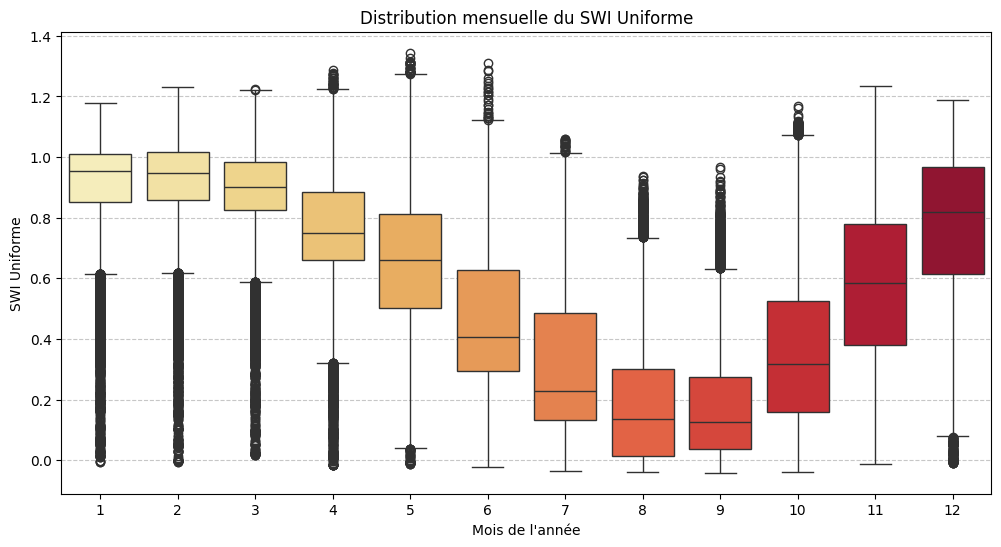

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

gdf_final['MOIS'] = gdf_final['DATE_quot'].dt.month
plt.figure(figsize=(12, 6))
sns.boxplot(x='MOIS', y='SWI_UNIF_MENS', data=gdf_final, palette='YlOrRd')
plt.title("Distribution mensuelle du SWI Uniforme")
plt.xlabel("Mois de l'année")
plt.ylabel("SWI Uniforme")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

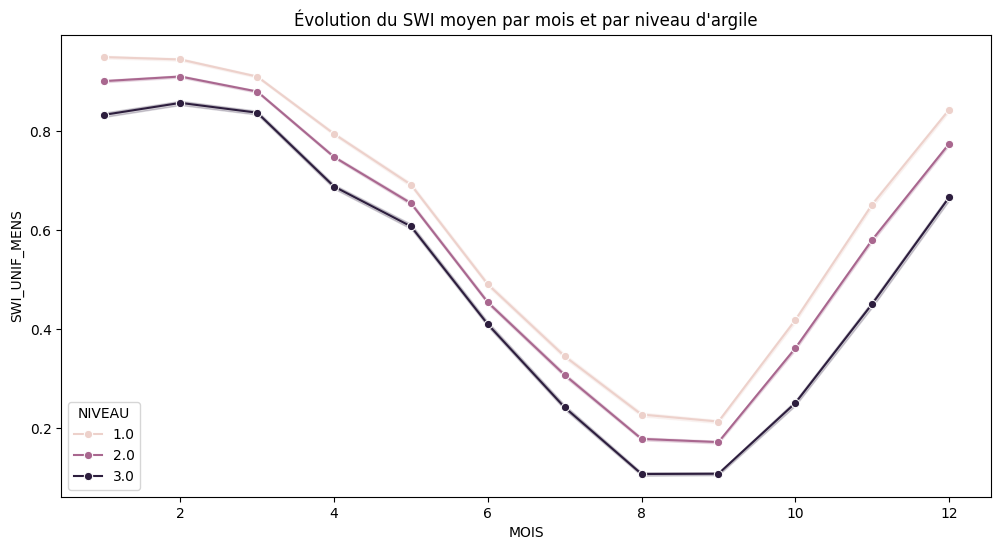

In [51]:
# Comparaison de l'évolution mensuelle selon l'aléa (Faible vs Fort)
plt.figure(figsize=(12, 6))
sns.lineplot(x='MOIS', y='SWI_UNIF_MENS', hue='NIVEAU', data=gdf_final, marker='o')
plt.title("Évolution du SWI moyen par mois et par niveau d'argile")
plt.show()

2-3. Agrégation régionale


/tmp/ipykernel_200811/790724977.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='SWI_UNIF_MENS', y='code_insee_de_la_region', data=df_regions_ete, palette='Oranges_r')


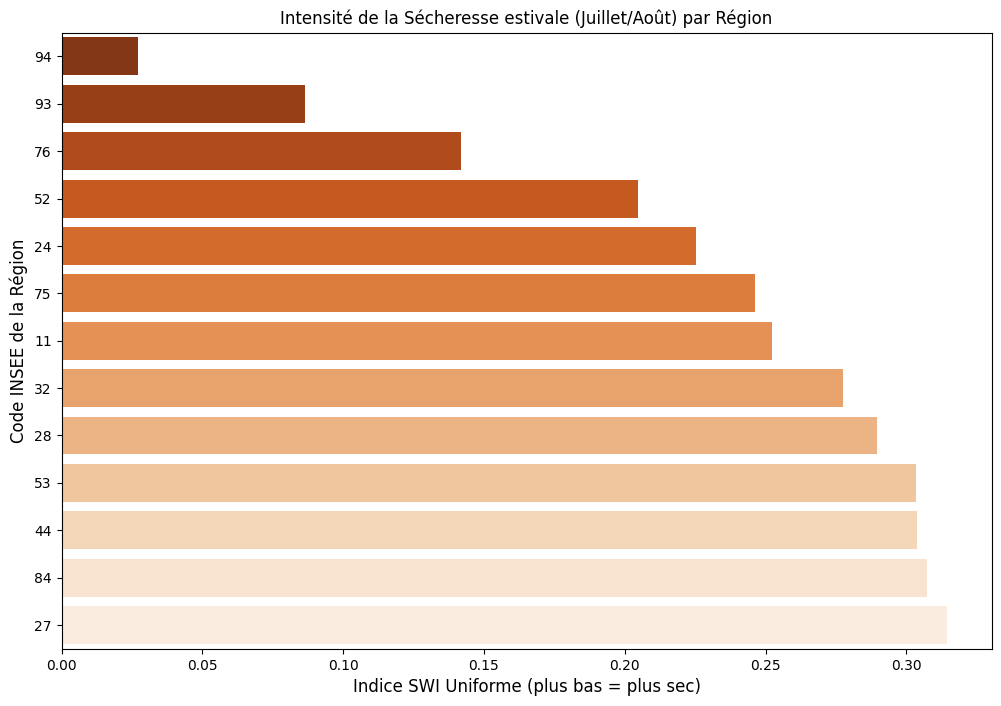

In [52]:
# 1. On filtre uniquement sur les mois les plus chauds (Juillet=7, Août=8)
df_ete = gdf_final[gdf_final['MOIS'].isin([7, 8])]

# 2. On recalcule la moyenne par région sur cette période critique
df_regions_ete = df_ete.groupby('code_insee_de_la_region')['SWI_UNIF_MENS'].mean().reset_index()

# 3. On trie
df_regions_ete = df_regions_ete.sort_values(by='SWI_UNIF_MENS', ascending=True)

# 4. Affichage du nouveau classement
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(x='SWI_UNIF_MENS', y='code_insee_de_la_region', data=df_regions_ete, palette='Oranges_r')
plt.title("Intensité de la Sécheresse estivale (Juillet/Août) par Région")
plt.xlabel("Indice SWI Uniforme (plus bas = plus sec)", fontsize=12)
plt.ylabel("Code INSEE de la Région", fontsize=12)
plt.show()

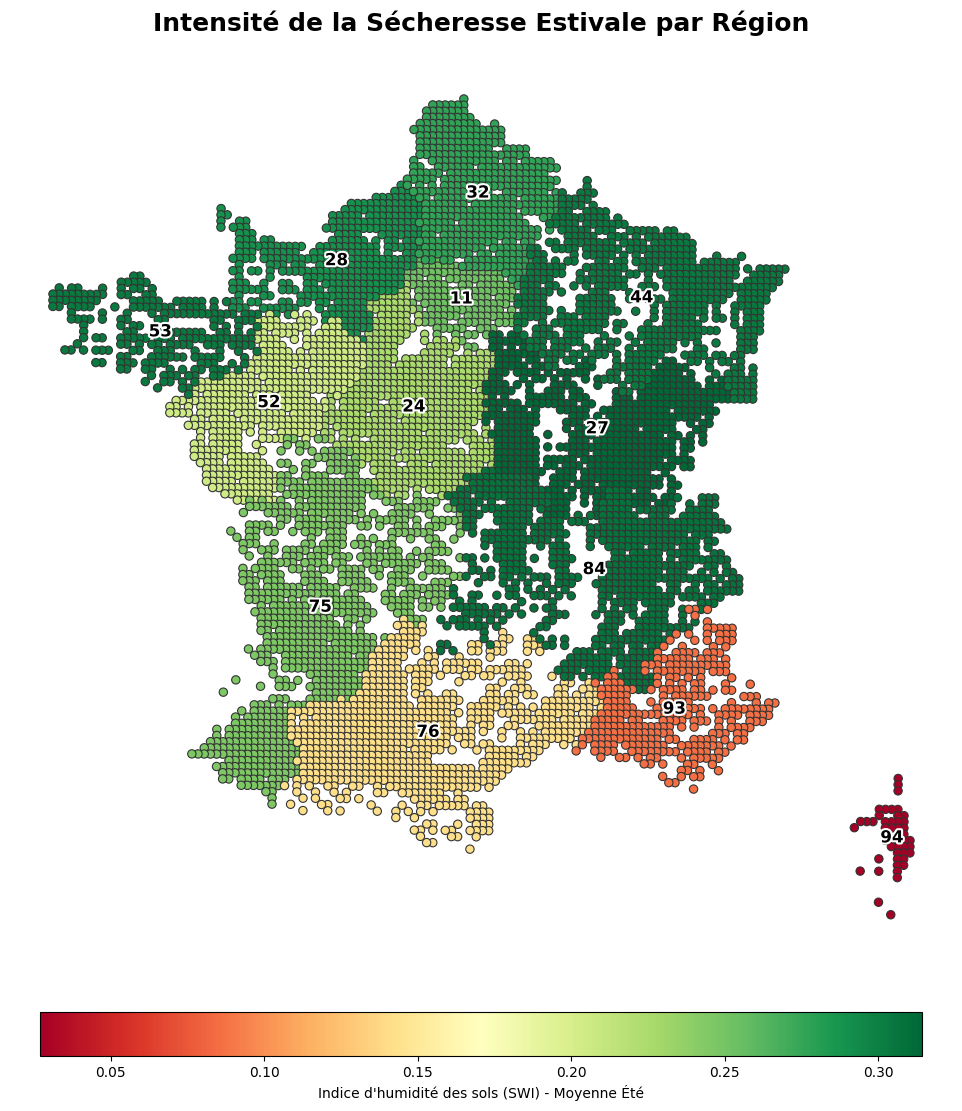

In [53]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects # L'importation manquante
import geopandas as gpd

# 1. Préparation des données (Moyenne Juillet/Août)
df_ete = gdf_final[gdf_final['MOIS'].isin([7, 8])].copy()
stats_ete = df_ete.groupby('code_insee_de_la_region')['SWI_UNIF_MENS'].mean().reset_index()

# 2. Création du fond de carte régional propre (Polygones)
# On utilise dissolve pour transformer les points/communes en grandes formes régionales
gdf_regions = gdf_final[['code_insee_de_la_region', 'geometry']].dissolve(by='code_insee_de_la_region').reset_index()

# 3. Fusion des données
gdf_map = gdf_regions.merge(stats_ete, on='code_insee_de_la_region')

# 4. Création de la figure haute résolution
fig, ax = plt.subplots(figsize=(15, 12))

# Tracé de la carte avec la palette 'RdYlGn' (Vert = Humide, Rouge = Sec)
gdf_map.plot(
    column='SWI_UNIF_MENS', 
    cmap='RdYlGn',       # Palette esthétique et très lisible
    legend=True,
    edgecolor='#333333', # Bordures gris foncé pour plus de netteté
    linewidth=0.8,
    ax=ax,
    legend_kwds={
        'label': "Indice d'humidité des sols (SWI) - Moyenne Été",
        'orientation': "horizontal",
        'pad': 0.05,
        'shrink': 0.6
    }
)

# 5. Ajout des étiquettes (Codes INSEE) au centre de chaque région
for x, y, label in zip(gdf_map.geometry.centroid.x, gdf_map.geometry.centroid.y, gdf_map['code_insee_de_la_region']):
    ax.annotate(
        label, xy=(x, y), 
        xytext=(0, 0), textcoords="offset points", 
        fontsize=12, fontweight='bold', color='black',
        ha='center', va='center',
        # Correction ici : on utilise patheffects au lieu de plt
        path_effects=[patheffects.withStroke(linewidth=3, foreground='white')] 
    )

# Finitions esthétiques
plt.title("Intensité de la Sécheresse Estivale par Région", fontsize=18, fontweight='bold', pad=20)
ax.set_axis_off() # Supprime les coordonnées (latitude/longitude) inutiles ici
plt.tight_layout()
plt.show()

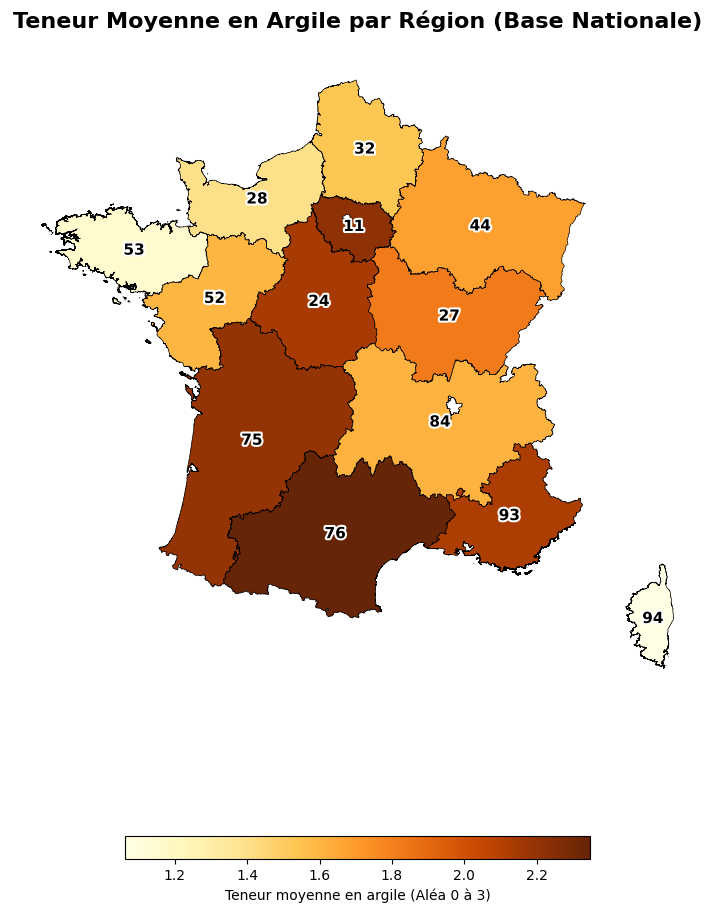

--- Classement des régions par teneur en argile ---
   code_insee_de_la_region    NIVEAU
9                       76  2.347436
0                       11  2.219355
8                       75  2.198622
1                       24  2.138889
11                      93  2.125000
2                       27  1.820738
5                       44  1.678072
10                      84  1.604683
6                       52  1.596413
4                       32  1.531868
3                       28  1.403694
7                       53  1.148936
12                      94  1.062500


In [54]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects

# 1. Calcul de la teneur moyenne par RÉGION pour toute la base
stats_reg = gdf_final.groupby('code_insee_de_la_region')['NIVEAU'].mean().reset_index()

# 2. Création du fond de carte régional (dissolution de toutes les communes de la base)
gdf_france_reg = gdf_communes.dissolve(by='code_insee_de_la_region').reset_index()

# 3. Fusion des statistiques avec le fond de carte
gdf_map_argile = gdf_france_reg.merge(stats_reg, on='code_insee_de_la_region')

# 4. Affichage de la carte nationale
fig, ax = plt.subplots(figsize=(12, 12))

gdf_map_argile.plot(
    column='NIVEAU', 
    cmap='YlOrBr', # Dégradé Jaune -> Brun pour l'argile
    legend=True,
    edgecolor='black',
    linewidth=0.5,
    ax=ax,
    legend_kwds={'label': "Teneur moyenne en argile (Aléa 0 à 3)", 'orientation': "horizontal", 'shrink': 0.5}
)

# Ajout des codes régions avec contour blanc
for x, y, label in zip(gdf_map_argile.geometry.centroid.x, gdf_map_argile.geometry.centroid.y, gdf_map_argile['code_insee_de_la_region']):
    ax.annotate(label, xy=(x, y), ha='center', va='center', fontsize=11, fontweight='bold',
                path_effects=[patheffects.withStroke(linewidth=3, foreground='white')])

plt.title("Teneur Moyenne en Argile par Région (Base Nationale)", fontsize=16, fontweight='bold')
plt.axis('off')
plt.show()

# 5. Affichage du classement texte
print("--- Classement des régions par teneur en argile ---")
print(stats_reg.sort_values(by='NIVEAU', ascending=False))

2-4 Corrélation entre les deux indice et Différences spatiales expliquées par la teneur en argile

In [31]:

# Calcul de la corrélation globale
correlation = gdf_final['SWI_MENS'].corr(gdf_final['SWI_UNIF_MENS'])
print(f"Corrélation globale entre SWI et SWI Uniforme : {correlation:.3f}")

# Calcul de la divergence (différence absolue)
gdf_final['DIVERGENCE'] = (gdf_final['SWI_MENS'] - gdf_final['SWI_UNIF_MENS']).abs()

# Statistiques de divergence par niveau d'argile
print("\nDivergence moyenne par niveau d'aléa argile :")
print(gdf_final.groupby('NIVEAU')['DIVERGENCE'].mean())

Corrélation globale entre SWI et SWI Uniforme : 0.964

Divergence moyenne par niveau d'aléa argile :
NIVEAU
1.0    0.082948
2.0    0.091157
3.0    0.109021
Name: DIVERGENCE, dtype: float64


Étape 3 : Entraînement du Modèle

Echantillon

In [55]:
# Filtrage sur le code INSEE de la région (76)
# Assurez-vous que la colonne est bien au format string ou int selon votre base
gdf_occ = gdf_final_complet[gdf_final_complet['code_insee_de_la_region'].astype(str) == '76'].copy()

print(f"Nombre de lignes pour la région Occitanie : {gdf_occ.shape[0]}")
print(f"Nombre de départements représentés : {gdf_occ['code_insee_du_departement'].nunique()}")

Nombre de lignes pour la région Occitanie : 46800
Nombre de départements représentés : 13


(np.float64(407151.92),
 np.float64(869015.0800000001),
 np.float64(6121972.850000001),
 np.float64(6454796.55))

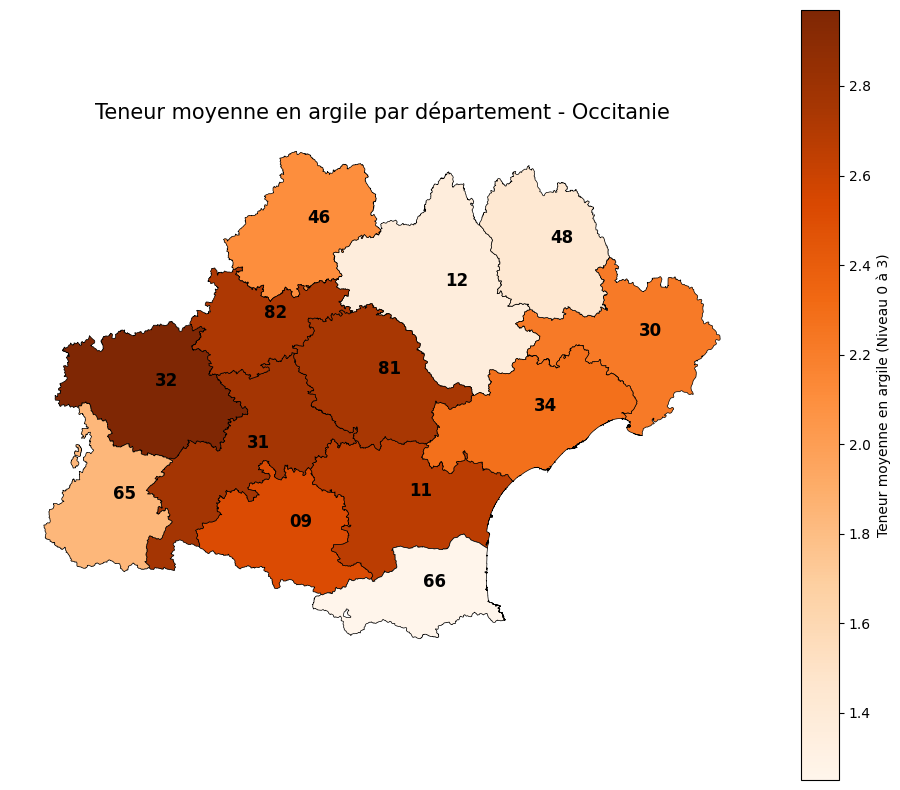

In [56]:
import matplotlib.pyplot as plt

# 1. Calcul de la teneur moyenne par département dans la région 76
# On utilise la colonne 'NIVEAU' qui va de 0 à 3 (Nul à Fort)
stats_dpt = gdf_occ.groupby('code_insee_du_departement')['NIVEAU'].mean().reset_index()

# 2. Fusion de ces stats avec le fond de carte des communes (dissous par département)
# On crée un fond de carte départemental à partir de vos polygones communaux
gdf_dpt_map = gdf_communes[gdf_communes['code_insee_de_la_region'].astype(str) == '76'].dissolve(by='code_insee_du_departement')
gdf_dpt_map = gdf_dpt_map.merge(stats_dpt, on='code_insee_du_departement')

# 3. Affichage de la carte
fig, ax = plt.subplots(figsize=(12, 10))

# Fond de carte choroplèthe (couleur selon le niveau d'argile)
gdf_dpt_map.plot(column='NIVEAU', cmap='Oranges', legend=True, 
                 edgecolor='black', linewidth=0.5, ax=ax,
                 legend_kwds={'label': "Teneur moyenne en argile (Niveau 0 à 3)"})

# Ajout des étiquettes des départements
for x, y, label in zip(gdf_dpt_map.geometry.centroid.x, gdf_dpt_map.geometry.centroid.y, gdf_dpt_map['code_insee_du_departement']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=12, fontweight='bold')

plt.title("Teneur moyenne en argile par département - Occitanie", fontsize=15)
plt.axis('off')

In [57]:
# 1. Remplacer les virgules par des points (conversion str -> str)
gdf_occ['SWI_UNIF_MENS'] = gdf_occ['SWI_UNIF_MENS'].str.replace(',', '.')

# 2. Convertir maintenant en nombre (str -> float)
gdf_occ['SWI_UNIF_MENS'] = gdf_occ['SWI_UNIF_MENS'].astype(float)

In [58]:
# Sélection des prédicteurs numériques et catégoriels encodés
# Nous incluons les indices de précipitations à différentes échelles (SPI)
X = gdf_occ[['LAMBX', 'LAMBY', 'PRENEI_MENS', 'PRELIQ_MENS', 'PRETOTM_MENS', 'T_MENS', 'EVAP_MENS', 'ETP_MENS', 'PE_MENS', 'SWI_MENS', 'DRAINC_MENS', 'RUNC_MENS', 'SPI1_MENS', 'SPI3_MENS', 'SPI6_MENS', 'SPI12_MENS', 'SSWI1_MENS', 'SSWI3_MENS', 'SSWI6_MENS', 'SSWI12_MENS', 'ECOULEMENT_MENS', 'NIVEAU']]
y = gdf_occ['SWI_UNIF_MENS']

In [59]:
y.head()

104441    0.980
104442    0.931
104443    1.072
104444    0.984
104445    1.005
Name: SWI_UNIF_MENS, dtype: float64

Random Forest Regressor

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Séparation temporelle : on garde la dernière année pour le test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialisation et entraînement
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [61]:
# Prédictions
y_pred = rf_model.predict(X_test)

# Métriques
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Précision du modèle (R²) : {r2:.3f}")
print(f"Erreur moyenne quadratique (MSE) : {mse:.5f}")

Précision du modèle (R²) : 0.991
Erreur moyenne quadratique (MSE) : 0.00097


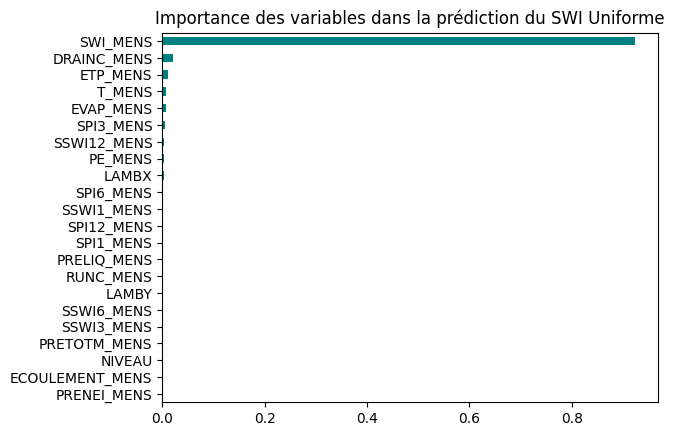

In [62]:


importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', color='teal')
plt.title("Importance des variables dans la prédiction du SWI Uniforme")
plt.show()

XGBoost

In [63]:
#pip install xgboost lightgbm
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


# --- MODÈLE XGBOOST ---
model_xgb = xgb.XGBRegressor(
    n_estimators=500, 
    learning_rate=0.05, 
    max_depth=6, 
    random_state=42,
    objective='reg:squarederror'
)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)

# --- MODÈLE LIGHTGBM ---
model_lgb = lgb.LGBMRegressor(
    n_estimators=500, 
    learning_rate=0.05, 
    max_depth=6, 
    random_state=42
)
model_lgb.fit(X_train, y_train)
y_pred_lgb = model_lgb.predict(X_test)

# 2. Comparaison des résultats
print(f"XGBoost - R²: {r2_score(y_test, y_pred_xgb):.4f} | MSE: {mean_squared_error(y_test, y_pred_xgb):.5f}")
print(f"LightGBM - R²: {r2_score(y_test, y_pred_lgb):.4f} | MSE: {mean_squared_error(y_test, y_pred_lgb):.5f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4940
[LightGBM] [Info] Number of data points in the train set: 37440, number of used features: 22
[LightGBM] [Info] Start training from score 0.467172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

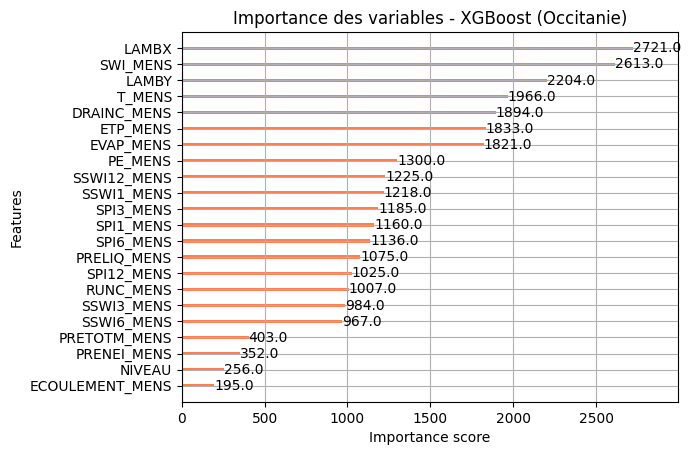

In [64]:
# Exemple avec XGBoost
xgb.plot_importance(model_xgb, importance_type='weight', color='coral')
plt.title("Importance des variables - XGBoost (Occitanie)")
plt.show()

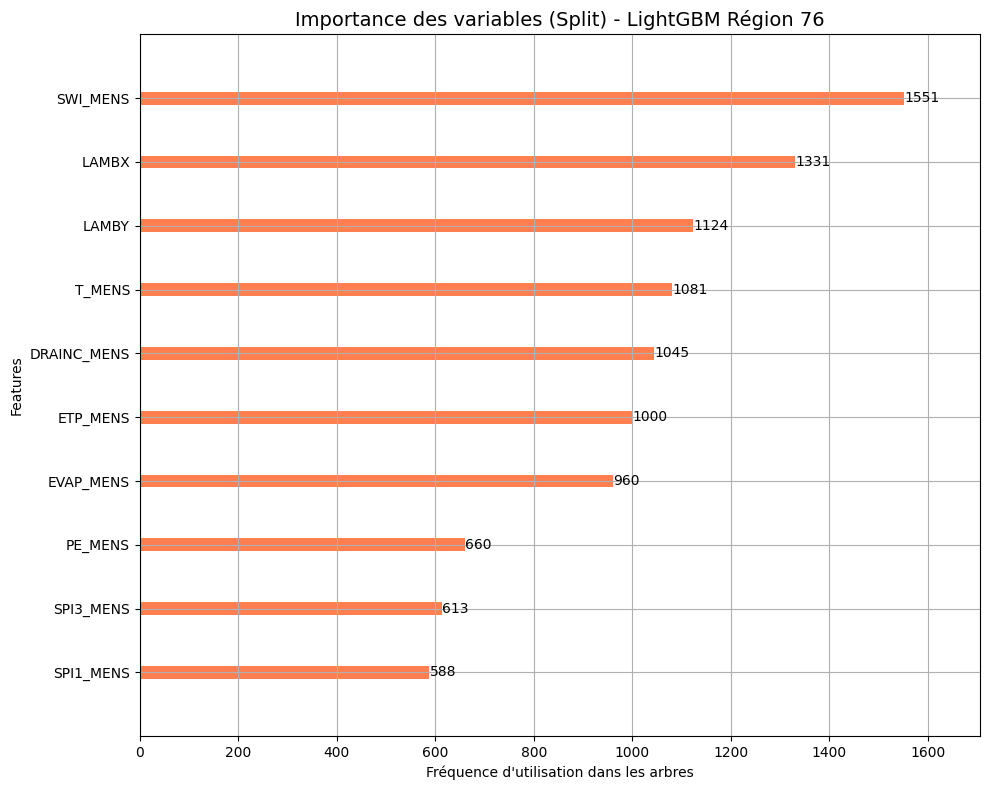

In [65]:
import lightgbm as lgb
import matplotlib.pyplot as plt

# 1. Utilisation de 'split' au lieu de 'weight'
plt.figure(figsize=(10, 8))
lgb.plot_importance(
    model_lgb, 
    importance_type='split',  # 'split' est le terme correct pour LightGBM
    color='coral', 
    ax=plt.gca(),
    max_num_features=10       # Pour garder le graphique lisible
)

plt.title("Importance des variables (Split) - LightGBM Région 76", fontsize=14)
plt.xlabel("Fréquence d'utilisation dans les arbres")
plt.tight_layout()
plt.show()

In [66]:
#Comparaison des résultats
print("--- Affichage du tableau comparatif ---")
print(f"Random Forest- R²: {r2_score(y_test, y_pred):.4f} | MSE: {mean_squared_error(y_test, y_pred):.5f}")
print(f"XGBoost - R²: {r2_score(y_test, y_pred_xgb):.4f} | MSE: {mean_squared_error(y_test, y_pred_xgb):.5f}")
print(f"LightGBM - R²: {r2_score(y_test, y_pred_lgb):.4f} | MSE: {mean_squared_error(y_test, y_pred_lgb):.5f}")

--- Affichage du tableau comparatif ---
Random Forest- R²: 0.9912 | MSE: 0.00097
XGBoost - R²: 0.9912 | MSE: 0.00097
LightGBM - R²: 0.9898 | MSE: 0.00113


Les modeles sur toute la base

In [67]:
# Sélection des prédicteurs numériques et catégoriels encodés
# Nous incluons les indices de précipitations à différentes échelles (SPI)
X = gdf_final[['LAMBX', 'LAMBY', 'PRENEI_MENS', 'PRELIQ_MENS', 'PRETOTM_MENS', 'T_MENS','SWI_MENS', 'EVAP_MENS', 'ETP_MENS', 'PE_MENS', 'DRAINC_MENS', 'RUNC_MENS', 'SPI1_MENS', 'SPI3_MENS', 'SPI6_MENS', 'SPI12_MENS', 'SSWI1_MENS', 'SSWI3_MENS', 'SSWI6_MENS', 'SSWI12_MENS', 'ECOULEMENT_MENS', 'NIVEAU']]
y = gdf_final['SWI_UNIF_MENS']

Précision du modèle (R²) : 0.994
Erreur moyenne quadratique (MSE) : 0.00064


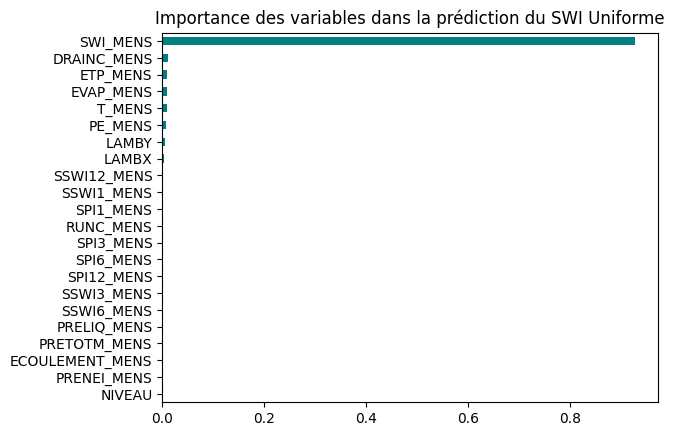

In [68]:
# Séparation temporelle : on garde la dernière année pour le test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialisation et entraînement
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
# Prédictions
y_pred = rf_model.predict(X_test)

# Métriques
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Précision du modèle (R²) : {r2:.3f}")
print(f"Erreur moyenne quadratique (MSE) : {mse:.5f}")
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', color='teal')
plt.title("Importance des variables dans la prédiction du SWI Uniforme")
plt.show()

XGBoost et LIGHTGBM

In [69]:

# --- MODÈLE XGBOOST ---
model_xgb = xgb.XGBRegressor(
    n_estimators=500, 
    learning_rate=0.05, 
    max_depth=6, 
    random_state=42,
    objective='reg:squarederror'
)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)

# --- MODÈLE LIGHTGBM ---
model_lgb = lgb.LGBMRegressor(
    n_estimators=500, 
    learning_rate=0.05, 
    max_depth=6, 
    random_state=42
)
model_lgb.fit(X_train, y_train)
y_pred_lgb = model_lgb.predict(X_test)

# 2. Comparaison des résultats
print(f"XGBoost - R²: {r2_score(y_test, y_pred_xgb):.4f} | MSE: {mean_squared_error(y_test, y_pred_xgb):.5f}")
print(f"LightGBM - R²: {r2_score(y_test, y_pred_lgb):.4f} | MSE: {mean_squared_error(y_test, y_pred_lgb):.5f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5108
[LightGBM] [Info] Number of data points in the train set: 296400, number of used features: 22
[LightGBM] [Info] Start training from score 0.578836
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
XGBoost - R²: 0.9888 | MSE: 0.00124
LightGBM - R²: 0.9869 | MSE: 0.00146


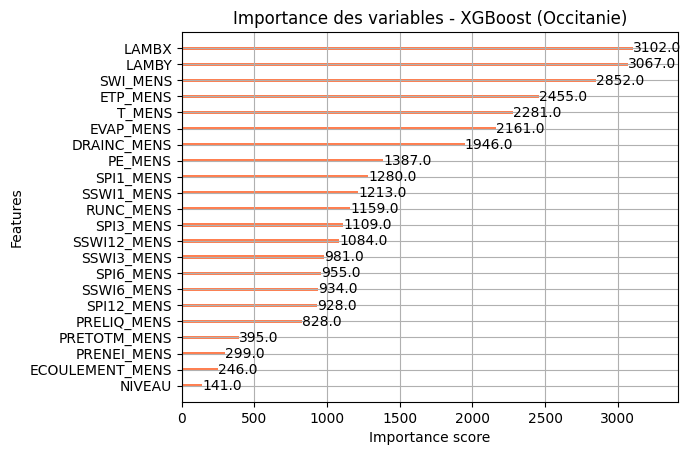

In [70]:
# Exemple avec XGBoost
xgb.plot_importance(model_xgb, importance_type='weight', color='coral')
plt.title("Importance des variables - XGBoost (Occitanie)")
plt.show()

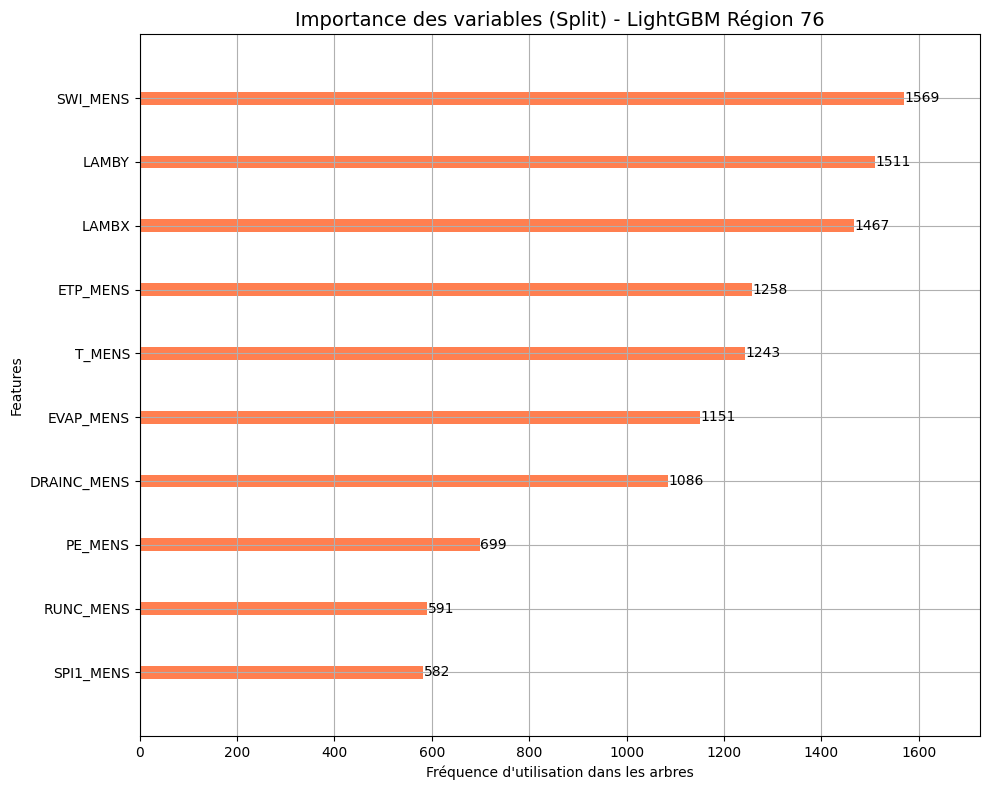

In [71]:
import lightgbm as lgb
import matplotlib.pyplot as plt

# 1. Utilisation de 'split' au lieu de 'weight'
plt.figure(figsize=(10, 8))
lgb.plot_importance(
    model_lgb, 
    importance_type='split',  # 'split' est le terme correct pour LightGBM
    color='coral', 
    ax=plt.gca(),
    max_num_features=10       # Pour garder le graphique lisible
)

plt.title("Importance des variables (Split) - LightGBM Région 76", fontsize=14)
plt.xlabel("Fréquence d'utilisation dans les arbres")
plt.tight_layout()
plt.show()

In [72]:
#Comparaison des résultats
print("--- Affichage du tableau comparatif ---")
print(f"Random Forest- R²: {r2_score(y_test, y_pred):.4f} | MSE: {mean_squared_error(y_test, y_pred):.5f}")
print(f"XGBoost - R²: {r2_score(y_test, y_pred_xgb):.4f} | MSE: {mean_squared_error(y_test, y_pred_xgb):.5f}")
print(f"LightGBM - R²: {r2_score(y_test, y_pred_lgb):.4f} | MSE: {mean_squared_error(y_test, y_pred_lgb):.5f}")

--- Affichage du tableau comparatif ---
Random Forest- R²: 0.9942 | MSE: 0.00064
XGBoost - R²: 0.9888 | MSE: 0.00124
LightGBM - R²: 0.9869 | MSE: 0.00146


Le modèle chosit est XGBoost

3. Interpretation & Communication

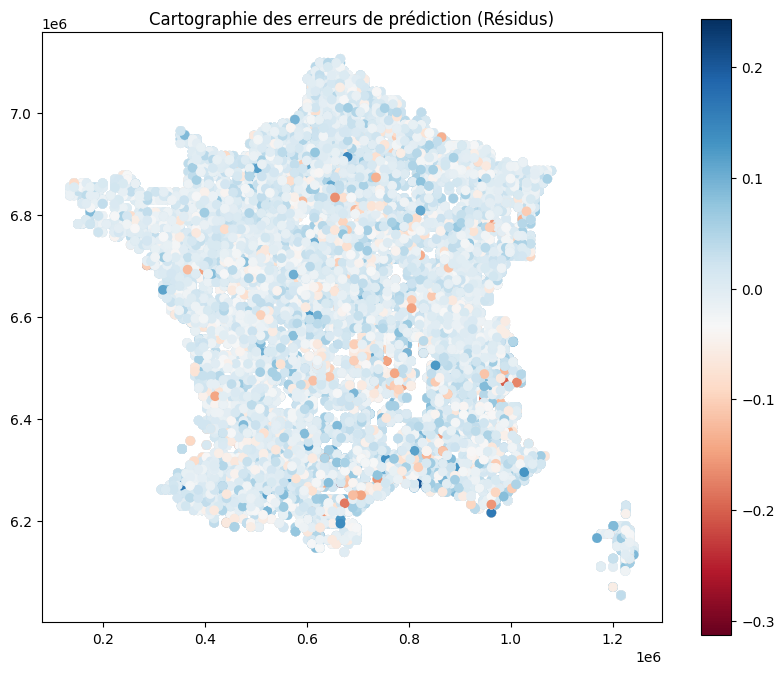

In [73]:
# Calcul des résidus sur le jeu de test
y_pred = model_xgb.predict(X_test)
residus = y_test - y_pred

# Visualisation spatiale des erreurs (exemple pour l'Occitanie)
gdf_test = gdf_final.loc[X_test.index].copy()
gdf_test['Erreur'] = residus

fig, ax = plt.subplots(figsize=(10, 8))
gdf_test.plot(column='Erreur', cmap='RdBu', legend=True, ax=ax)
plt.title("Cartographie des erreurs de prédiction (Résidus)")
plt.show()

In [90]:
import pandas as pd

# 1. On définit les trimestres (ex: Q2 = Avril, Mai, Juin)
# Assurez-vous d'avoir une colonne 'TRIMESTRE' ou créez-la
gdf_final['TRIMESTRE'] = gdf_final['DATE_quot'].dt.quarter

# 2. Calcul du 25ème percentile par commune et par trimestre
# Cela crée une référence historique propre à chaque lieu
thresholds = gdf_final.groupby(['code_insee_de_la_region', 'TRIMESTRE'])['SWI_UNIF_MENS'].quantile(0.25).reset_index()
thresholds.rename(columns={'SWI_UNIF_MENS': 'SEUIL_Q25'}, inplace=True)

# 3. Fusion de ces seuils avec la base principale
df_model = gdf_final.merge(thresholds, on=['code_insee_de_la_region', 'TRIMESTRE'])

# 4. Création de la variable cible binaire (Label)
# 1 = Sécheresse Extrême (SWI < Seuil), 0 = Normal
df_model['IS_EXTREME_DROUGHT'] = (df_model['SWI_UNIF_MENS'] < df_model['SEUIL_Q25']).astype(int)

In [91]:
df_model.head()

,LAMBX,LAMBY,DATE_quot,PRENEI_MENS,PRELIQ_MENS,PRETOTM_MENS,T_MENS,EVAP_MENS,ETP_MENS,PE_MENS,...,nom_officiel,code_insee,codes_insee_des_arrondissements,code_insee_du_departement,code_insee_de_la_region,MOIS,DIVERGENCE,TRIMESTRE,SEUIL_Q25,IS_EXTREME_DROUGHT
0,840,24010,2020-01,0.0,127.1,127.1,8.3,17.2,14.6,109.9,...,Saint-Renan,2927,291,29,53,1,0.064,1,0.933,0
1,840,24010,2020-02,0.0,173.7,173.7,9.1,29.7,21.9,144.0,...,Saint-Renan,2927,291,29,53,2,0.066,1,0.933,0
2,840,24010,2020-03,0.0,72.9,72.9,8.4,38.2,42.4,34.7,...,Saint-Renan,2927,291,29,53,3,0.068,1,0.933,0
3,840,24010,2020-04,0.0,71.7,71.7,12.1,61.5,72.5,10.2,...,Saint-Renan,2927,291,29,53,4,0.086,2,0.509,0
4,840,24010,2020-05,0.0,21.2,21.2,14.5,94.0,123.1,-72.8,...,Saint-Renan,2927,291,29,53,5,0.067,2,0.509,0


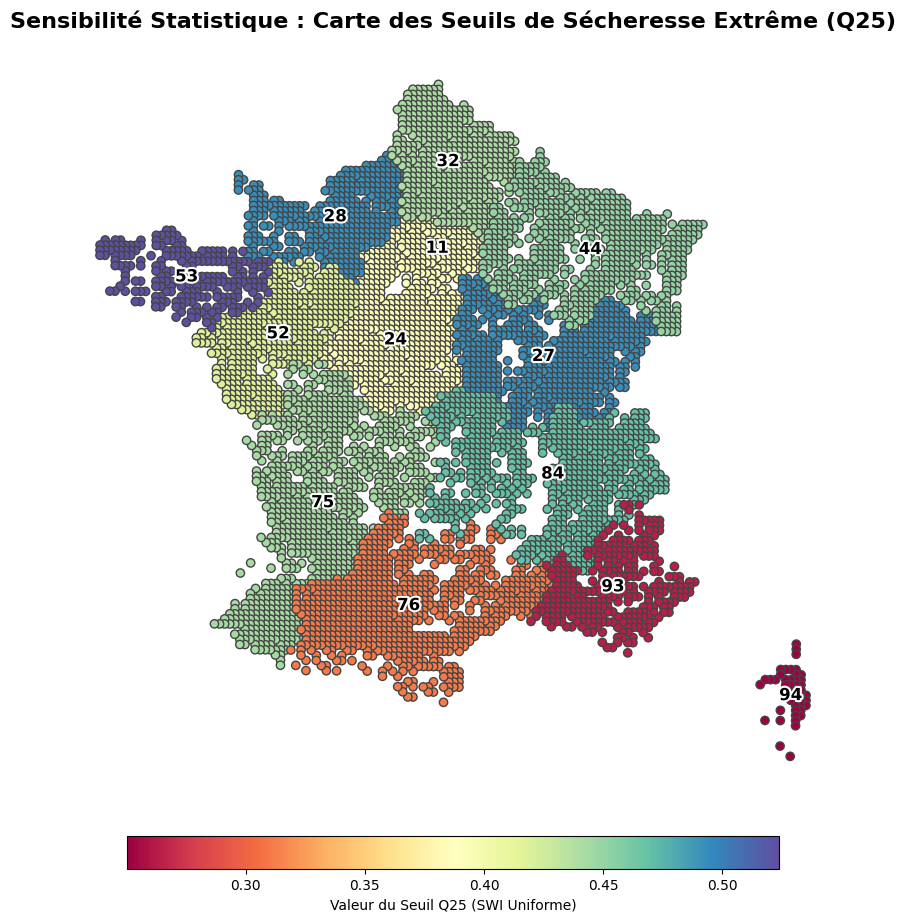

In [92]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
import geopandas as gpd

# 1. Calcul du seuil Q25 par région pour l'ensemble de l'année
# (On agrège ici par région pour une lecture claire à l'échelle nationale)
stats_q25 = df_model.groupby('code_insee_de_la_region')['SEUIL_Q25'].mean().reset_index()

# 2. Préparation du fond de carte régional
gdf_regions = gdf_final[['code_insee_de_la_region', 'geometry']].dissolve(by='code_insee_de_la_region').reset_index()
gdf_map_q25 = gdf_regions.merge(stats_q25, on='code_insee_de_la_region')

# 3. Création de la figure
fig, ax = plt.subplots(figsize=(14, 12))

# Tracé de la carte
# Palette Spectral_r : les zones où le seuil est bas (sec) sont en rouge/orange
gdf_map_q25.plot(
    column='SEUIL_Q25', 
    cmap='Spectral', 
    legend=True,
    edgecolor='#444444',
    linewidth=1,
    ax=ax,
    legend_kwds={'label': "Valeur du Seuil Q25 (SWI Uniforme)", 'orientation': "horizontal", 'shrink': 0.6, 'pad': 0.05}
)

# 4. Ajout des étiquettes de régions
for idx, row in gdf_map_q25.iterrows():
    point = row.geometry.representative_point()
    ax.annotate(
        text=row['code_insee_de_la_region'],
        xy=(point.x, point.y),
        ha='center', va='center',
        fontsize=12, fontweight='bold',
        path_effects=[patheffects.withStroke(linewidth=3, foreground='white')]
    )

plt.title("Sensibilité Statistique : Carte des Seuils de Sécheresse Extrême (Q25)", fontsize=16, fontweight='bold')
plt.axis('off')
plt.show()